In [39]:
from subprocess import run
from re import sub
from pydot import graph_from_dot_data
from IPython.display import Image, display, SVG

In [11]:
# A function which calls 'melos ls' in a subprocess
def melos_ls(args:list):
  result = run(['melos', 'ls', '-r'] + args, cwd='../', capture_output=True)
  return result.stdout.decode('utf-8'), result.returncode == 0

In [12]:
# JSON format
JT, JTsuccess = melos_ls(['--json', '-l'])
print(f'Success: {JTsuccess}')

Success: True


In [13]:
# JSON relational graph format
GT, GTsuccess = melos_ls(['--graph'])
print(f'Success: {GTsuccess}')

Success: True


In [45]:
# Graphviz format
GV, GVsuccess = melos_ls(['--gviz'])

# For some reason, melos outputs ";" inside the "[]"
# instead of "," so we reformat with regex:
GV = sub(r'(\[.*)(\;)(.*\])', r'\1,\3', GV)

# Ensure that the subprocess was successful
print(f'Success: {GVsuccess}')

Success: True


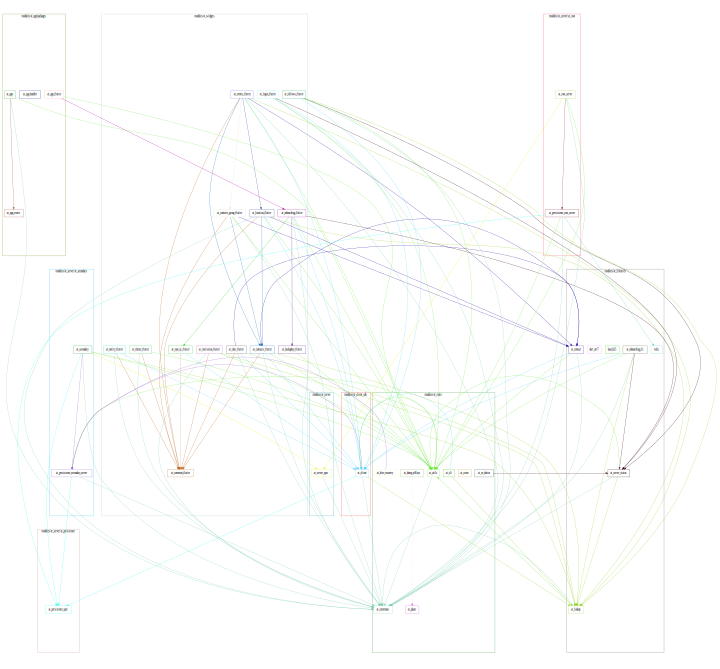

In [46]:
# Plot the Graphviz format
graphs = graph_from_dot_data(GV)
plt = SVG(graphs[0].create(prog='dot', format='svg'))
display(plt)